# Basic Neural Network Dosage Tutorial

## Introduction
This tutorial demonstrates how to train a simple neural network to fit specific target points (a "dosage" function). You'll learn:
- How to build a custom neural network with partially frozen weights
- The concept of training only specific parameters while keeping others fixed
- How gradient descent optimizes a network to match target outputs
- Visualization of network behavior before and after training

## Learning Objectives
1. Understand a two-branch neural network architecture with ReLU activations
2. Learn why we might freeze certain weights during training
3. Observe how a single trainable parameter (bias) can shift the entire function
4. Practice implementing a training loop with PyTorch

## 1. Import Required Libraries

In [1]:
# Import necessary PyTorch modules and matplotlib for visualization
import torch
import torch.nn as nn  # Neural network building blocks
import torch.nn.functional as F  # Activation functions like ReLU
import torch.optim as optim  # Optimization algorithms (SGD, Adam, etc.)

import matplotlib.pyplot as plt  # For plotting our network's output

## 2. Network Architecture

This tutorial is based on the StatQuest video series on neural networks:
https://www.youtube.com/watch?v=FHdlXe1bSe4&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1&index=29

### Understanding the Architecture
Our network has a unique two-branch structure:
- **Top Branch**: Processes input through one set of weights and biases
- **Bottom Branch**: Processes the same input through different weights and biases
- **Final Output**: Combines both branches and adds a trainable bias

The key insight: All weights are frozen (not trainable) except the final bias. This demonstrates how a single parameter can shift an entire pre-defined function.

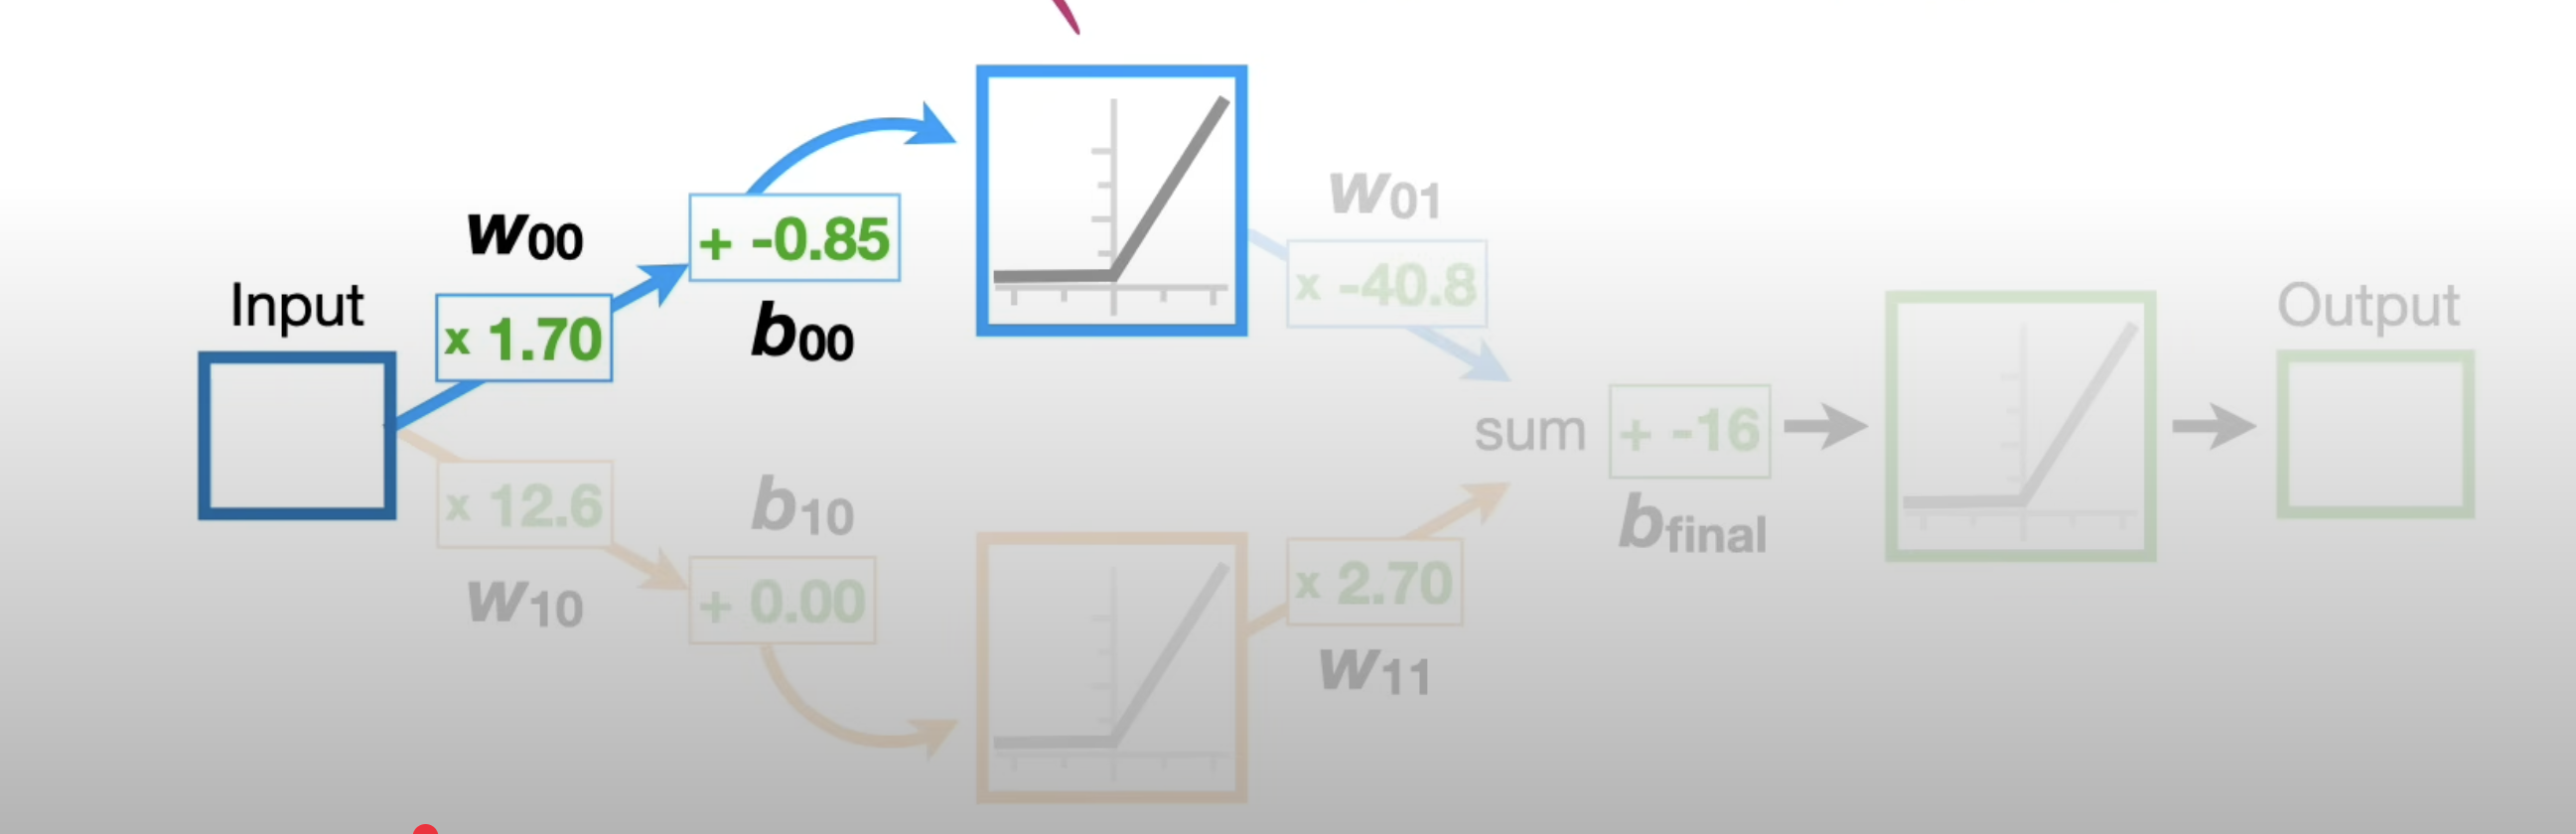

### Mathematical Representation
```
Top Branch:    ReLU(input × w00 + b00) × w01
Bottom Branch: ReLU(input × w10 + b10) × w11
Output:        ReLU(Top + Bottom + final_bias)
```

The pre-set weights create a specific curve shape, and we'll train only the `final_bias` to shift this curve vertically to match our target points.

## 3. Define the Neural Network Class

In [2]:
class Net(nn.Module):
    """
    A two-branch neural network with mostly frozen weights.
    Only the final bias parameter is trainable, demonstrating how a single
    parameter can shift an entire pre-defined function.
    """
    def __init__(self) -> None:
        super().__init__()
        
        # Top branch parameters (all frozen - requires_grad=False)
        self.w00 = nn.Parameter(torch.tensor(1.70), requires_grad=False)  # First weight for top branch
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)  # First bias for top branch
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)  # Second weight for top branch

        # Bottom branch parameters (all frozen)
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)  # First weight for bottom branch
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)   # First bias for bottom branch
        self.w11 = nn.Parameter(torch.tensor(2.70), requires_grad=False)  # Second weight for bottom branch

        # The ONLY trainable parameter - this will be optimized during training
        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    def forward(self, input):
        """
        Forward pass through the network.
        
        Args:
            input: Input tensor (can be single value or batch)
            
        Returns:
            Output after processing through both branches and final activation
        """
        # Top branch: Apply first linear transform, ReLU, then second weight
        top = F.relu(input * self.w00 + self.b00) * self.w01
        
        # Bottom branch: Apply first linear transform, ReLU, then second weight
        bottom = F.relu(input * self.w10 + self.b10) * self.w11
        
        # Combine branches, add trainable bias, and apply final ReLU
        return F.relu(top + bottom + self.final_bias)

## 4. Create Test Input and Visualize Initial Network Output

Let's create a range of input values and see what our network outputs before training.

In [3]:
# Create a range of input values from 0 to 1 for testing
input = torch.linspace(0, 1, 11)  # 11 evenly spaced points
print("Input values:", input)

Input values: tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])


In [4]:
# Initialize the network with pre-defined weights
net = Net()
print(f"Initial final_bias value: {net.final_bias.item():.4f}")

Initial final_bias value: 0.0000


In [5]:
# Get the network's output for our input range (before training)
output = net(input)
print("Output shape:", output.shape)

Output shape: torch.Size([11])


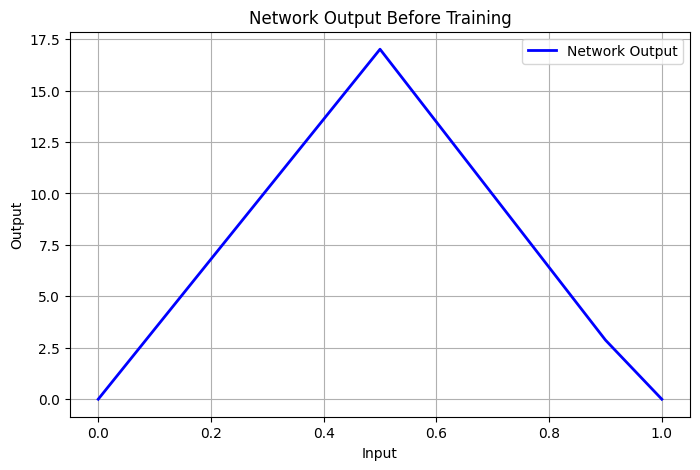

In [6]:
# Visualize the network's initial output function
plt.figure(figsize=(8, 5))
plt.plot(input, output.detach(), 'b-', linewidth=2, label='Network Output')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Network Output Before Training')
plt.grid(True)
plt.legend()
plt.show()

## 5. Define Training Data

We want our network to output specific values at three points:
- At input 0.0 → output 0.0
- At input 0.5 → output 1.0 (peak)
- At input 1.0 → output 0.0

This creates a "dosage" response curve that peaks in the middle.

In [7]:
# Define our training data - three key points we want the network to match
data_input = torch.Tensor([0., 0.5, 1.])  # Input values
data_labels = torch.Tensor([0., 1., 0.])  # Desired outputs

print("Training data:")
for i in range(len(data_input)):
    print(f"  Input: {data_input[i]:.1f} → Target Output: {data_labels[i]:.1f}")

Training data:
  Input: 0.0 → Target Output: 0.0
  Input: 0.5 → Target Output: 1.0
  Input: 1.0 → Target Output: 0.0


## 5.1 Understanding Backpropagation Mathematics

Let's understand what happens mathematically during training:

### The Chain Rule in Action
For our network with input `x`, the computation flow is:
1. Top branch: `t = ReLU(x * w00 + b00) * w01`
2. Bottom branch: `b = ReLU(x * w10 + b10) * w11`
3. Output: `y = ReLU(t + b + final_bias)`
4. Loss: `L = (y - target)²`

When we call `loss.backward()`, PyTorch computes:
```
∂L/∂final_bias = ∂L/∂y × ∂y/∂final_bias
               = 2(y - target) × 1  (if y > 0)
               = 2(y - target)
```

### Gradient Accumulation Example
With our three training points:
- Point 1 (x=0.0, target=0.0): Computes gradient₁
- Point 2 (x=0.5, target=1.0): Computes gradient₂
- Point 3 (x=1.0, target=0.0): Computes gradient₃

After the inner loop:
```
final_bias.grad = gradient₁ + gradient₂ + gradient₃
```

### The SGD Update Rule
When `optimizer.step()` is called:
```
final_bias_new = final_bias_old - learning_rate × final_bias.grad
               = final_bias_old - 0.001 × (gradient₁ + gradient₂ + gradient₃)
```

This moves the parameter in the direction that reduces the total loss across all samples!

## 6. Understanding PyTorch Training: backward(), step(), and zero_grad()

Before we start training, let's understand three critical PyTorch methods:

### 1. **loss.backward()** - Computing Gradients
- Performs automatic differentiation (backpropagation)
- Calculates gradients (derivatives) of the loss with respect to all parameters with `requires_grad=True`
- Uses the chain rule to traverse the computation graph backwards
- **Important**: Gradients are ACCUMULATED (added), not replaced

### 2. **optimizer.step()** - Updating Parameters
- Uses the computed gradients to update model parameters
- Applies the optimization algorithm (SGD in our case): `parameter = parameter - learning_rate * gradient`
- Only updates parameters that have `requires_grad=True`

### 3. **optimizer.zero_grad()** - Clearing Gradients
- Resets all gradients to zero
- **Critical**: Must be called before the next iteration because PyTorch accumulates gradients by default
- Without this, gradients from multiple epochs would add up incorrectly

### Why Gradient Accumulation?
In our training loop, we call `backward()` for each sample, accumulating gradients:
```python
for sample in batch:
    loss = compute_loss(sample)
    loss.backward()  # Adds this sample's gradient to .grad
# All gradients accumulated
optimizer.step()  # Update using total gradient
```

This is mathematically equivalent to:
```python
total_loss = loss1 + loss2 + loss3
total_loss.backward()  # Compute gradient of sum
optimizer.step()
```

But the first approach is more memory-efficient!

## 6.1 The Training Loop Explained

In [8]:
# Setup optimizer - SGD will only update parameters with requires_grad=True (just final_bias)
optimizer = optim.SGD(net.parameters(), lr=0.001)  # Learning rate of 0.001

# Training configuration
max_epochs = 100000000  # Maximum number of epochs (will stop early if converged)
target_loss = 0.0001    # Stop training when total loss is below this threshold
print_frequency = 10000  # Print progress every N epochs

# Track loss history for visualization
loss_history = []
epoch_history = []

print("Starting training...")
print(f"Target: Total loss < {target_loss}")
print("-" * 50)

# Training loop - each epoch processes all training samples
for epoch in range(max_epochs):
    total_loss = 0
    
    # MINI-BATCH PROCESSING: Iterate through each training sample
    # We accumulate gradients across all samples before updating weights
    for iteration in range(len(data_input)):
        input_i = data_input[iteration]
        label_i = data_labels[iteration]
        
        # FORWARD PASS: compute network output for this sample
        output_i = net(input_i)
        
        # LOSS CALCULATION: Mean Squared Error for this sample
        loss = (output_i - label_i) ** 2
        
        # Track total loss for monitoring (using Python float, not tensor)
        total_loss += float(loss)
        
        # BACKWARD PASS: Compute gradients and ACCUMULATE them
        # This adds the gradient from this sample to any existing gradients
        # Key insight: d(loss1 + loss2)/dx = d(loss1)/dx + d(loss2)/dx
        loss.backward()
        
        # Note: We do NOT call optimizer.step() here!
        # We're accumulating gradients from all 3 samples first
    
    # After processing all samples, the gradients are fully accumulated
    # final_bias.grad now contains: d(loss_sample0 + loss_sample1 + loss_sample2)/d(final_bias)
    
    # Store loss history (sample every 100 epochs for efficiency)
    if epoch % 100 == 0:
        loss_history.append(total_loss)
        epoch_history.append(epoch)
    
    # Print progress periodically
    if epoch % print_frequency == 0:
        print(f'Epoch {epoch:8d}: Total Loss = {total_loss:.6f}, Final Bias = {net.final_bias.item():.6f}')
    
    # Check convergence criterion
    if total_loss < target_loss:
        # Add final point to history
        loss_history.append(total_loss)
        epoch_history.append(epoch)
        
        print("-" * 50)
        print(f'✓ Converged at epoch {epoch}!')
        print(f'  Final total loss: {total_loss:.6f}')
        print(f'  Final bias value: {net.final_bias.item():.6f}')
        break
    
    # PARAMETER UPDATE: Use accumulated gradients to update parameters
    # For SGD: final_bias = final_bias - learning_rate * final_bias.grad
    optimizer.step()
    
    # GRADIENT RESET: Clear gradients for next epoch
    # Without this, gradients would keep accumulating across epochs (wrong!)
    optimizer.zero_grad()

print("-" * 50)
print(f'Training complete!')
print(f'Final bias parameter: {net.final_bias.item():.6f}')

Starting training...
Target: Total loss < 0.0001
--------------------------------------------------
Epoch        0: Total Loss = 256.320099, Final Bias = 0.000000


/var/folders/28/s5vm3lsx1pbbsph6h5kmljqr0000gn/T/ipykernel_59680/2068329570.py:34: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_loss += float(loss)


--------------------------------------------------
✓ Converged at epoch 3686!
  Final total loss: 0.000100
  Final bias value: -16.000008
--------------------------------------------------
Training complete!
Final bias parameter: -16.000008


## 6.5 Visualize Training Loss Over Time

Let's visualize how the loss decreased during training to understand the optimization process.

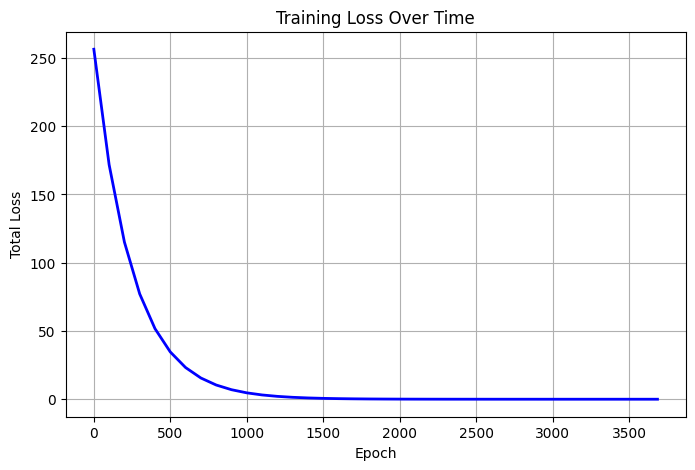

Training completed in 3686 epochs
Final loss: 0.000100


In [9]:
# Visualize how the loss decreased during training
plt.figure(figsize=(8, 5))
plt.plot(epoch_history, loss_history, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Print training statistics
print(f"Training completed in {epoch_history[-1]} epochs")
print(f"Final loss: {loss_history[-1]:.6f}")

## 7. Visualize Results After Training

Let's see how well our network learned to match the target points by plotting the final output function.

In [10]:
# Get the network's output after training
output_trained = net(input)

# Also get outputs for our specific training points to verify
training_outputs = [net(x).item() for x in data_input]
print("Training point verification:")
for i in range(len(data_input)):
    print(f"  Input: {data_input[i]:.1f} → Output: {training_outputs[i]:.4f} (Target: {data_labels[i]:.1f})")

Training point verification:
  Input: 0.0 → Output: 0.0000 (Target: 0.0)
  Input: 0.5 → Output: 1.0100 (Target: 1.0)
  Input: 1.0 → Output: 0.0000 (Target: 0.0)


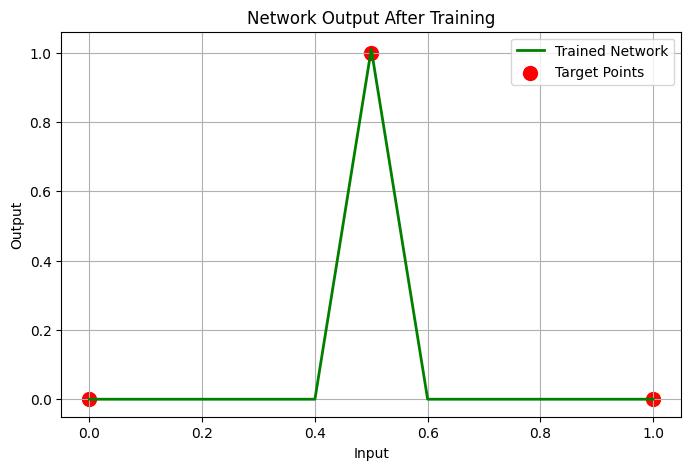

Training Results:
  Input 0.0: Output 0.000 (Target 0.0)
  Input 0.5: Output 1.010 (Target 1.0)
  Input 1.0: Output 0.000 (Target 0.0)


In [11]:
# Visualize the results after training
plt.figure(figsize=(8, 5))
plt.plot(input, output_trained.detach(), 'g-', linewidth=2, label='Trained Network')
plt.scatter(data_input, data_labels, color='red', s=100, label='Target Points')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Network Output After Training')
plt.grid(True)
plt.legend()
plt.show()

# Show how well we matched the targets
print("Training Results:")
for i in range(len(data_input)):
    actual = net(data_input[i]).item()
    target = data_labels[i].item()
    print(f"  Input {data_input[i]:.1f}: Output {actual:.3f} (Target {target:.1f})")